In [1]:
import pandas as pd 
from subs.energy_api import *


df_carbon_forecast_indexed =carbon_api_forecast()


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-01 18:00:00,CO2_INTENSITY_FORECAST,ALL,194.4433
2024-02-01 18:30:00,CO2_INTENSITY_FORECAST,ALL,195.9673
2024-02-01 19:00:00,CO2_INTENSITY_FORECAST,ALL,195.6091
2024-02-01 19:30:00,CO2_INTENSITY_FORECAST,ALL,193.0147
2024-02-01 20:00:00,CO2_INTENSITY_FORECAST,ALL,186.7111
2024-02-01 20:30:00,CO2_INTENSITY_FORECAST,ALL,177.8176
2024-02-01 21:00:00,CO2_INTENSITY_FORECAST,ALL,161.0213
2024-02-01 21:30:00,CO2_INTENSITY_FORECAST,ALL,145.6480
2024-02-01 22:00:00,CO2_INTENSITY_FORECAST,ALL,135.4890


In [3]:
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carbon_intensity_recent["Value"] = df_carbon_intensity_recent[


In [5]:
df_carbon_intensity_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-01-31 18:00:00,CO2_INTENSITY,ALL,198.0
2024-01-31 18:15:00,CO2_INTENSITY,ALL,199.0
2024-01-31 18:30:00,CO2_INTENSITY,ALL,196.0
2024-01-31 18:45:00,CO2_INTENSITY,ALL,197.0
2024-01-31 19:00:00,CO2_INTENSITY,ALL,197.0
...,...,...,...
2024-02-01 16:45:00,CO2_INTENSITY,ALL,219.0
2024-02-01 17:00:00,CO2_INTENSITY,ALL,220.0
2024-02-01 17:15:00,CO2_INTENSITY,ALL,221.0


In [6]:
co2_stats_prior_day

{'mean': 227.36458333333334, 'min': 167.0, 'max': 289.0}

In [7]:
def classify_status(value, min_val, max_val):
    if value < min_val:
        return 'low'
    elif value > max_val:
        return 'high'
    else:
        return 'medium'
    
df_carbon_forecast_indexed['status_compared_to_yesterday'] = df_carbon_forecast_indexed['Value'].apply(classify_status, args=(co2_stats_prior_day['min'], co2_stats_prior_day['max']))
df_carbon_forecast_indexed['status_compared_to_EU'] = df_carbon_forecast_indexed['Value'].apply(classify_status, args=(250, 500))
    

In [8]:
df_carbon_forecast_indexed

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-01 18:00:00,CO2_INTENSITY_FORECAST,ALL,194.4433,medium,low
2024-02-01 18:30:00,CO2_INTENSITY_FORECAST,ALL,195.9673,medium,low
2024-02-01 19:00:00,CO2_INTENSITY_FORECAST,ALL,195.6091,medium,low
2024-02-01 19:30:00,CO2_INTENSITY_FORECAST,ALL,193.0147,medium,low
2024-02-01 20:00:00,CO2_INTENSITY_FORECAST,ALL,186.7111,medium,low
2024-02-01 20:30:00,CO2_INTENSITY_FORECAST,ALL,177.8176,medium,low
2024-02-01 21:00:00,CO2_INTENSITY_FORECAST,ALL,161.0213,low,low
2024-02-01 21:30:00,CO2_INTENSITY_FORECAST,ALL,145.6480,low,low
2024-02-01 22:00:00,CO2_INTENSITY_FORECAST,ALL,135.4890,low,low


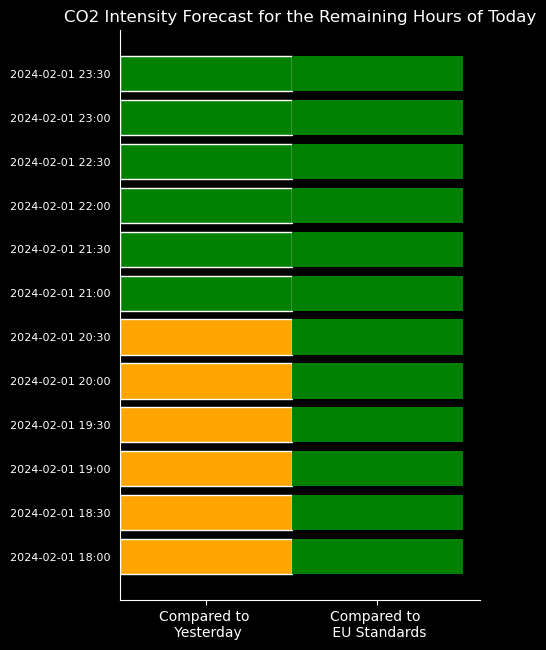

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Assuming df_carbon_forecast_indexed is your DataFrame
df = df_carbon_forecast_indexed.reset_index(inplace=False)
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])
df.sort_values('EffectiveTime', inplace=True)

# Map status to colors
color_map = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 6))

# Plot a bar for each row in the DataFrame.
for i, (index, row) in enumerate(df.iterrows()):
    # Use the index i as the y-coordinate for the bar.
    ax.barh(i, 1, color=color_map[row['status_compared_to_yesterday']], edgecolor='white')
    ax.barh(i, 1, left=1, color=color_map[row['status_compared_to_EU']], edgecolor='none')

# Customize plot appearance.
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.tick_params(axis='x', colors='white')  # X-axis ticks color.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Remove x-axis ticks.
ax.xaxis.set_ticks([])

# Set y-axis labels.
# Convert EffectiveTime to the desired string format and use it as y-tick labels.
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['EffectiveTime'].dt.strftime('%Y-%m-%d %H:%M'), color='white', fontsize=8)

# Ensure everything fits without overlap.
plt.tight_layout()


ax.set_title('CO2 Intensity Forecast for the Remaining Hours of Today', color='white')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Compared to \n Yesterday', 'Compared to \n EU Standards'], color='white')

# Display the plot.
plt.show()

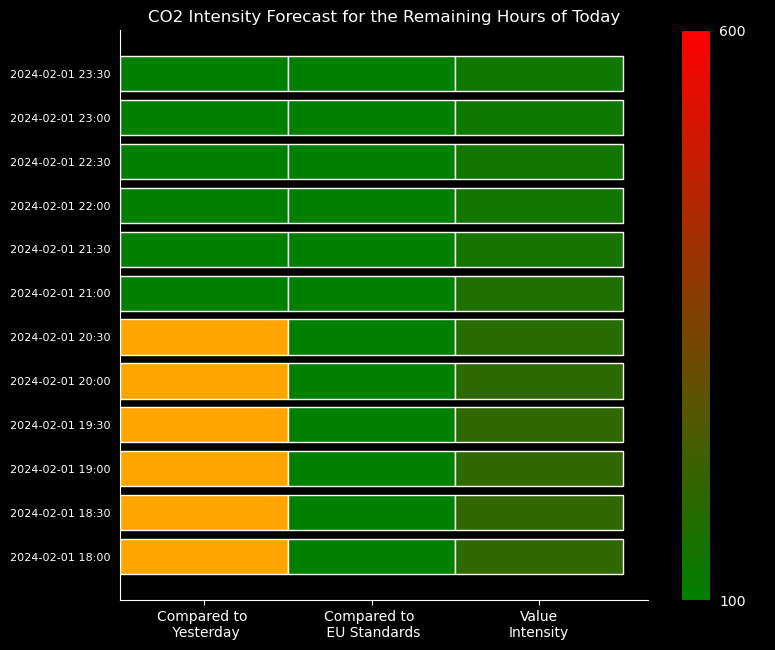

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Assuming df_carbon_forecast_indexed is your DataFrame
df = df_carbon_forecast_indexed.reset_index(inplace=False)
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])
df.sort_values('EffectiveTime', inplace=True)

# Map status to colors
color_map = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create a custom colormap from green to red
cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_red", ["green", "red"])

# Normalize the "Value" data to [0, 1]
norm = mcolors.Normalize(vmin=100, vmax=600)

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figure size for additional bars and color bar

# Plot a bar for each row in the DataFrame.
for i, (index, row) in enumerate(df.iterrows()):
    ax.barh(i, 1, color=color_map[row['status_compared_to_yesterday']], edgecolor='white')
    ax.barh(i, 1, left=1, color=color_map[row['status_compared_to_EU']], edgecolor='white')
    # Use the custom colormap and normalized values to determine the color for the "Value" column.
    ax.barh(i, 1, left=2, color=cmap(norm(row['Value'])), edgecolor='white')

# Customize plot appearance.
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.tick_params(axis='x', colors='white')  # X-axis ticks color.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Remove x-axis ticks.
ax.xaxis.set_ticks([])

# Set y-axis labels.
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['EffectiveTime'].dt.strftime('%Y-%m-%d %H:%M'), color='white', fontsize=8)

plt.tight_layout()

ax.set_title('CO2 Intensity Forecast for the Remaining Hours of Today', color='white')
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['Compared to \n Yesterday', 'Compared to \n EU Standards', 'Value\nIntensity'], color='white')

# Create and customize the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Value Intensity')
cbar.set_ticks([norm.vmin, norm.vmax])  # Set ticks to the min and max of the data
cbar.set_ticklabels([100, 600],color='white')  # Format min and max values as labels


# Display the plot.
plt.show()


In [12]:
df_carbon_intensity_recent.loc['2024-01-30']

,FieldName,Region,Value
EffectiveTime,,,
2024-01-30 16:45:00,CO2_INTENSITY,ALL,226.0
2024-01-30 17:00:00,CO2_INTENSITY,ALL,219.0
2024-01-30 17:15:00,CO2_INTENSITY,ALL,216.0
2024-01-30 17:30:00,CO2_INTENSITY,ALL,212.0
2024-01-30 17:45:00,CO2_INTENSITY,ALL,209.0
2024-01-30 18:00:00,CO2_INTENSITY,ALL,213.0
2024-01-30 18:15:00,CO2_INTENSITY,ALL,214.0
2024-01-30 18:30:00,CO2_INTENSITY,ALL,208.0
2024-01-30 18:45:00,CO2_INTENSITY,ALL,206.0
